<a href="https://colab.research.google.com/github/Acclesia/aiffel-project/blob/master/%5BE_5%5D_Spectrogram_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-5] Spectrogram classification

* 2차원 Spectrogram 데이터 받아 기본버전과 skip-connection버전으로 학습

## 루브릭 평가 기준
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
 * 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
= yes!! 

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
 * 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
= yes!

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
 * evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다
 = 정확도는 83% 나왔다. 다른 모델로도 해보고 싶은데 학습하는데만 밤새 걸려서 엄두가 안난다....ㅎ

### 1. 데이터 처리와 분류

    라벨 데이터 처리하기
    sklearn의 train_test_split함수를 이용하여 train, test 분리


In [ ]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [ ]:
#데이터셋은 1초 길이의 오디오 음성데이터가 50620개 
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print(type(speech_data['label_vals']))
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
<class 'numpy.ndarray'>
✅


In [ ]:
import numpy as np 
np.unique(speech_data['label_vals']).tolist()

['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

In [ ]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(3, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  46987
Wave data shape :  (8000,)
label :  ['silence']


In [ ]:
#1차원 데이터 2차원의 spectrogram 데이터로 변경
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [ ]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


!!! 목요일 오후) 현재..랜덤으로 뽑은 데이터만 2차원으로 바뀐거 같다..
전체 데이터를 for문으로 돌려서 2차원 spectogram으로 만들어야 하는거 같다..
하지만 나는 지금 gpu가 이상하고 아나콘다도 없어져서 커널이랑 가상환경도 못한다...
코드를 바꿔도 epoch하는데만 반나절 걸리기 때문에 이 상태로 제출..흑ㅠㅠ

In [ ]:
#label data 처리 
#텍스트로 된 라벨데이터를 index로 바꾸는 작업
target_list = np.unique(speech_data['label_vals']).tolist()

label_value = target_list
print('LABEL:',label_value)

new_label_value = dict()
for i,l in enumerate(label_value): 
    new_label_value[l]=i
label_value = new_label_value

print('Indexed LABEL:',new_label_value)

LABEL: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
Indexed LABEL: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 8, 'unknown': 9, 'up': 10, 'yes': 11}


In [ ]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([0, 0, 0, ..., 7, 7, 7])

In [ ]:
#데이터 분리
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])                                                    

[[ 1.00075779e-03  1.73614006e-02  4.10028100e-02 ... -1.82687435e-02
  -3.35108256e-03 -1.32366419e-02]
 [ 4.17793356e-02 -6.42028451e-02  1.20232284e-01 ... -2.43684966e-02
  -1.44415060e-02 -5.88012394e-03]
 [-3.24792485e-03 -5.92566608e-03 -4.83857142e-03 ... -2.38697045e-04
  -7.78569665e-05 -8.65458918e-04]
 ...
 [ 3.47291680e-05  8.66069677e-05  1.13667338e-05 ... -2.19892354e-05
  -3.12858174e-05 -5.31450278e-05]
 [-4.29282751e-04 -5.81529108e-04 -5.38978085e-04 ... -5.20958216e-04
  -5.23725001e-04 -6.15365396e-04]
 [ 9.90237808e-04 -6.52900722e-04 -2.69066379e-03 ...  8.42041103e-04
  -3.21515166e-04 -1.10193924e-03]]


In [ ]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (40496, 8000, 1)
train labels :  (40496,)
test data :  (10124, 8000, 1)
test labels :  (10124,)


# Hyper-parameters setting

In [ ]:
batch_size = 16
max_epochs = 5

# the save point
checkpoint_dir = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
checkpoint_dir

'/home/aiffel-dj54/aiffel/speech_recognition/data/speech_wav_8000.npz'

# Data setting
- tf. data,dataset을 사용해서 데이터셋을 구성한다. 
- tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 넣는다

In [ ]:
#map 함수에 넘겨줄 데이터 전처리 함수 
#one-hot-encoding

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [ ]:
# tf. data. dataset. 함수구성
import tensorflow as tf

# for train 
# return 받길 원하는 데이터는 train_wav, train_label
# tensor slice 함수를 통해 데이터를 정리해준다
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label) # train_wav, train_label를 받으면 return으로 무엇을 반환할지 결정
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


값을 해석해보면 batctdataset shape 에는 wav 가 없고 label 이 8000(?), depth = 1 / train label: none label이 12???? (????)

In [ ]:

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


#  2차원 Spectrogram 데이터를 처리하는 모델 구성
* 자연어 처리 분야에서 사용하는 합성곱의 경우 각 단어 벡터의 차원 전체에 대해 필터를 적용시키기 위해 주로 conv1D를 사용한다
* padding 은 same(입력 사이즈가 같아지게 하는거) or valid(padding을 안하는 것)
* activation은 활성화 함수 넣는 것- relu 넣음 
* maxpool1D() : 맥스풀링은 특징 맵에서 최대값만 뽑아내는 방식이다. 
* pooling은 featue map 크기를 줄이거나 주요한 특징을 뽑아내기 위해서 적용된다.
* 종류는 MaxPool1D, MaxPool2D, MaxPool3D으로 나눠진다.

In [ ]:

from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

#dropout 레이어는 과적합을 방지하기 위해서 특정 확률만큼 노드의 값을 0으로 만든다.
#drop out(0.3)(입력값) 전체 입력값 중에서 30%를 0으로 만든다.

In [ ]:
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

conv 1d layer 속성을 이해하면 2d를 이해할 수 , conv 2d 차이 
3차원 입력이 들어오면 1차원으로 연산을 처리는 1d, 2차원으로 연산하면 2d  
batch 32 epoch 10


In [ ]:
# loss 
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [ ]:
# call back: 학습 중간에 원하는 동작 할 수 있다./ 모델 가중치를 저장한다.
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                               save_weights_only=True,
                                                 monitor='val_loss', #val_loss를 모니터해서 loss가 낮아지면 모델 파라미터를 저장
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
# 모델 학습
history_wav = model_wav.fit(train_dataset,epochs=max_epochs,
                           steps_per_epoch=len(train_wav)//batch_size,
                           validation_data=test_dataset,
                           validation_steps=len(test_wav)//batch_size,
                           callbacks=[cp_callback]
                           )
print("ok")

Epoch 1/5
2531/2531 [==============================] - ETA: 0s - loss: 1.6669 - accuracy: 0.4332
Epoch 00001: val_loss improved from inf to 1.13983, saving model to /home/aiffel-dj54/aiffel/speech_recognition/data/speech_wav_8000.npz
2531/2531 [==============================] - 3377s 1s/step - loss: 1.6669 - accuracy: 0.4332 - val_loss: 1.1398 - val_accuracy: 0.6305
Epoch 2/5
2531/2531 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.6861
Epoch 00002: val_loss improved from 1.13983 to 0.78361, saving model to /home/aiffel-dj54/aiffel/speech_recognition/data/speech_wav_8000.npz
2531/2531 [==============================] - 3368s 1s/step - loss: 0.9886 - accuracy: 0.6861 - val_loss: 0.7836 - val_accuracy: 0.7524
Epoch 3/5
2531/2531 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.7835
Epoch 00003: val_loss improved from 0.78361 to 0.61224, saving model to /home/aiffel-dj54/aiffel/speech_recognition/data/speech_wav_8000.npz
2531/2531 [=========

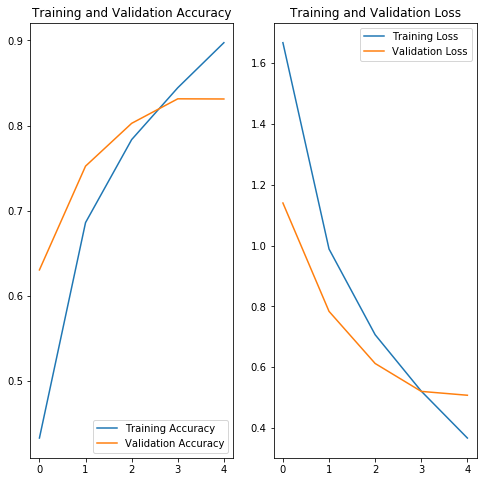

In [ ]:
# 학습결과 그래프
# 모델 학습한 결과를 기반으로 loss 와 accuracy 그래프 표현

import matplotlib.pyplot as plt

acc= history_wav.history['accuracy'] #정확도 
val_acc=history_wav.history['val_accuracy'] #학습한 모델의 정확도 

loss=history_wav.history['loss'] #loss
val_loss=history_wav.history['val_loss'] #학습한 모델의 손실

epochs_range = range(len(acc))

plt.figure(figsize=(8,8)) #그래프 그리기 
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right') #범례는 오른쪽 아래 
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 성능평가
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [ ]:
#테스트 데이터 이용해서 예측값과 실제값을 비교
results = model_wav.evaluate(test_dataset)

#loss
print("loss valu:{:.3f}".format(results[0]))

#accuracy
print("accuracy value:{:.4f}%".format(results[1]*100))

633/633 [==============================] - 232s 366ms/step - loss: 0.5077 - accuracy: 0.8312
loss valu:0.508
accuracy value:83.1193%


In [ ]:
# 모델 test
inv_label_value = {v:k for k,v in label_value.items()}
batch_index = np.random.choice(len(test_wav),size=1,replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_=model_wav(batch_xs,training=False)

print("label:",str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,),rate=8000)

label: off


In [ ]:
#테스트 셋 라벨과 실제와 비교해보기!
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: off(Correct!)


In [ ]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in test_spec:
    wav = spec2wav(spec)
    data_wav.append(wav)
data_wav = np.array(data_wav)
data_wav.shape

# 회고

1. 자연어에 익숙해지다.
- 처음에 자연어를 접했을땐 복잡하고 흐름이 잘 보이지 않았다. 용어도 헷갈리고 대충 이해만하고 넘어갔 이번 프로젝트를 진행하면서 흐름을 익힐 수 있었다. 
